In [1]:
import numpy as np
from matplotlib import pyplot as plt
from trig_fund import *
from dambreak import *
from syrup_prop import *

Janine Birnbaum

June 6, 2019

Model Herschel-Bulkley fluid flow along inclined surface

Flow equation:

$ h_t = \left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} $$ \left[ \frac{n|h_x|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right]h_x \right] $

$ Y = h - \frac{\tau_y}{\rho g |h_x|} $

Written in dimensionless form: 

$ h_t = \frac{\partial}{\partial x} \left[ \frac{n|h_x|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)}[(1+2n)h-nY]h_x \right] $

$ Y = h - \frac{B}{|h_x|} $

where B = $\frac{\tau_y L}{\rho g H^2}$

$ x = L x', h = Hh', Y = HY', t = \frac L H \left( \frac{KL}{\rho g H^2} \right)^{1/n} t' $

(Balmforth et al., 2007)

Generalized for Herschel-Bulkley fluid on a slope following derivation from Liu & Mei (1989):

$ h_t = \frac{\partial}{\partial x} \left[ \left( \frac{\rho g}{K} \right)^{1/n} \frac{n \left| \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right)|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".


Dimensional Analysis for spatially and temporally varying slope, density, consistency, and yield stress (constant n): 

$h = H \hat{h}, x = L \hat{x}, \theta = \theta_0 \hat{\theta}, \rho = \rho_0 \hat{\rho}, g = g_0 \hat{g}, K = K_0 \hat{K}, h = H \hat{h}$ 

For height-dominated flow: 

$ t = \frac L H \left( \frac{K_0 L}{\rho_0 g_0 H^2} \right)^{1/n} $

Plug in and drop the hat decoration: 

$ h_t = \frac{\partial}{\partial x} \left[ \left( \frac{\rho g}{K} \right)^{1/n} \frac{n \left| \frac L H \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \frac L H \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right) \right] $

$ Y = h - \frac{B \tau_y}{\rho g \left| \frac L H \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|} $

$ B = \frac{\tau_{y_0} L}{\rho_0 g_0 H^2} $

In [3]:
def dambreak_RK2(x, L, h0, H, theta, rho, K, tauy, n, g, ts, i):
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space on an inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2)) - Evaluation points in x [m].
     - *L*     (float)        - Characteristic scale in x [m].
     - *h0*    (ndarray(m+2)) - Initial height at evaluation points in x [m].
     - *H*     (float)        - Characteristic scale in z [m].
     - *theta* (ndarray(m+2)) - Slope in degrees at evaluation points in x [deg].
     - *rho*   (float)        - Fluid density [kg/m^3].
     - *K*     (float)        - Fluid consistency [Pa s].
     - *tauy*  (float)        - Yield stress [Pa].
     - *n*     (float)        - Rheology power law exponent.
     - *g*     (float)        - Gravitational constant [m/s^2].
     - *ts*    (float)        - Final time for simulation [sec].
     - *i*     (int)          - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
     - (ndarray(m+2, i+2)) - Yield Surface Y.
    """

    # Dimensional numbers
    A = L/H
    B = tauy*L/(rho*g*H**2)
    T = (L/H)*(K*L/(rho*g*H**2))**(1/n)
    tf = ts/T

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = tf/(i+1)
    t = np.linspace(0, tf, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))
    Y = np.zeros((i+2,x.size))
    
    # Initial condition
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        
        for j, s in enumerate([0.5, 1]): # Loops through twice for 2-step RK
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2 # Approximate h on the left and right to allow non-zero flow
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = A*sind(theta[2:]) - (h[k+j,2:]*cosd(theta[2:]) - h[k+j,1:-1]*cosd(theta[1:-1]))/dx[1:]
            hxl = A*sind(theta[1:-1]) - (h[k+j,1:-1]*cosd(theta[1:-1]) - h[k+j,:-2]*cosd(theta[:-2]))/dx[:-1]
            Yr  = hr - B/np.abs(hxr)
            Yl  = hl - B/np.abs(hxl)
        
            # Yield surface
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
            
            # Calculate flux
            Qr = n*(np.abs(hxr)**(1/n-1)*(Yr)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hr - n*Yr)*hxr
            Ql = n*(np.abs(hxl)**(1/n-1)*(Yl)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hl - n*Yl)*hxl
        
            # Eliminate nan for zero slope
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            Y[k,1:-1] = (Yr + Yl)/2
        
            # Update solution
            h[k+1,1:-1] = h[k,1:-1] - s*dt/dx[:-1]*(Qr - Ql)
            
            # Left boundary condition (no flow)
            h[k+1,0] = h[k+1,1]
    
    return h*H, t*T, Y

C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply


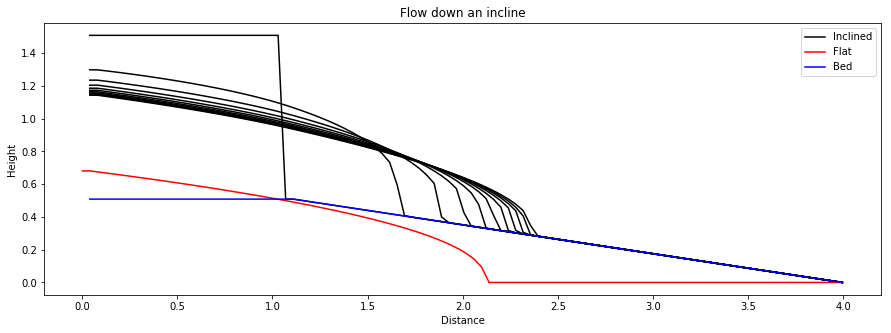

In [4]:
# Example calculation with spatially varying slope

# Problem setup
H = 1 # reservoir height in m
L = 1  # reservoir length in m
K = 1  # consistency in Pa s
rho = 1 # density in kg/m^3
g = 1   # gravitational acceleration m/s^2
tauy = 0.1 # yield stress in Pa
n = 1.5 # power law exponent

# Discretize domain 
m = 100
x = np.linspace(0, 4, m+2)
dx = x[1] - x[0]

ts = 50 # time in s
i = 50000

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = 1

# Bed topography
theta = np.zeros_like(x)
theta[x>=1.1] = 10
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

# Solve
h, t, Y = dambreak_RK2(x, L, h0, H, theta, rho, K, tauy, n, g, ts, i) # No slope for comparison
h2, t2, Y2 = dambreak_RK2(x, L, h0, H, np.zeros_like(theta), rho, K, tauy, n, g, ts, i)

# Plot result
fig,ax = plt.subplots(figsize=(15,5))
for k in 5000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Inclined');
ax.plot(x,h2[-1,:].transpose(),'r-',label='Flat');
ax.plot(x_trans,z0,'b-',label='Bed');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax.set_title('Flow down an incline');
ax.legend();

C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: overflow e

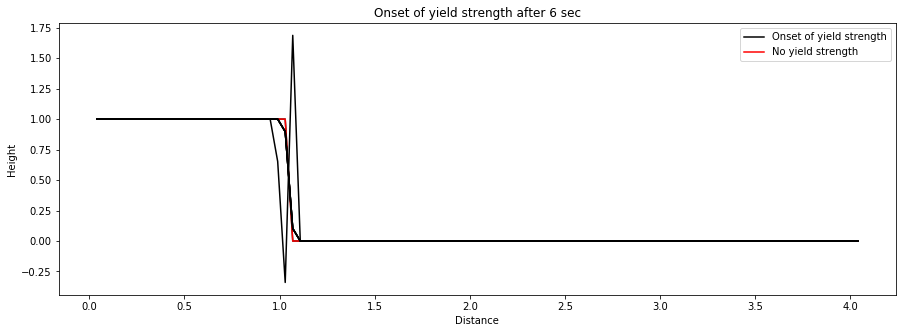

In [6]:
# Problem setup
H = 1 # reservoir height in m
L = 1  # reservoir length in m

g = 10   # gravitational acceleration m/s^2

# Discretize domain 
m = 100
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

ts = 10 # time in s
i = 100000

theta = 0*np.ones(m+2)

# Fluid propeties
n = 0.5*np.ones((i+2,m+2)) # power law exponent
K = np.ones((i+2,m+2))  # consistency in Pas
rho = np.ones((i+2,m+2)) # density in kg/m^3
tauy = 0*np.ones((i+2,m+2)) # yield stress in Pa
tauy[:30000,:] = 100

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = H

# Rotate coordinates for plotting
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

# Solve
h, t, Y = damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i)
h2, t2, Y2 = damBreak(x, h0, theta, rho, K, np.zeros((i+2,m+2)), n, g, ts, i)

# Plot result
fig,ax = plt.subplots(figsize=(15,5))
for k in 5000*np.arange(10): # Plot 10 snapshots
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-');
    ax.plot(x_trans,h2[k,:].transpose()*cosd(theta) + z0,'r-');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Onset of yield strength'); # Plot final state
ax.plot(x_trans,h2[-1,:].transpose()*cosd(theta) + z0,'r-',label='No yield strength');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax.set_title('Onset of yield strength after 6 sec');
ax.legend();

Text(0.5, 1.0, 'Temperature dependence of corn syrup viscosity')

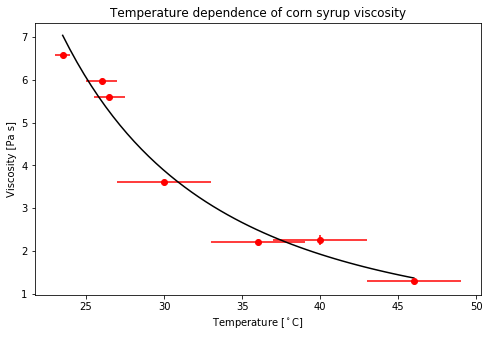

In [9]:
# Plot viscosity data and fit

T_fit = np.linspace(23.5, 46, 50)
Visc_fit = Visc(T_fit)
T_dat = [23.5, 26, 26.5, 30, 36, 40, 46]
T_err = [0.5, 1,1 , 3, 3, 3, 3]
Visc_dat = [6.588, 5.979, 5.592, 3.606, 2.204, 2.255, 1.303]
Visc_stdev = [0.032, 0.0064, 0.0064, 0.006, 0.0269, 0.112, 0.0386]

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(T_fit,Visc_fit,'k-')
ax.errorbar(T_dat, Visc_dat, xerr=T_err, yerr=Visc_stdev,
           linestyle='none', fmt='ro')
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.set_ylabel('Viscosity [Pa s]')
ax.set_title('Temperature dependence of corn syrup viscosity')

Text(0.5, 1.0, 'Temperature dependence of corn syrup viscosity')

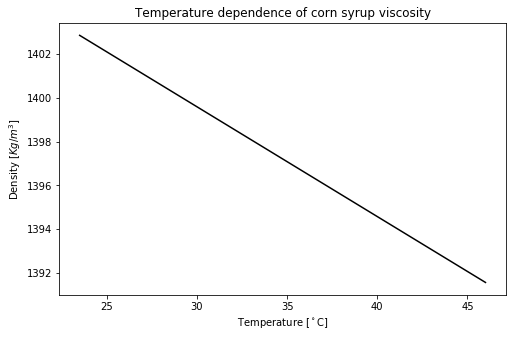

In [11]:
# Plot density data and fit
T_fit = np.linspace(23.5, 46, 50)
Density_fit = Density(T_fit)

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(T_fit,Density_fit,'k-')
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.set_ylabel('Density [$Kg/m^3$]')
ax.set_title('Temperature dependence of corn syrup viscosity')

In [ ]:
# Problem setup
H = 0.06 # reservoir height in m
L = 0.20  # reservoir length in m

g = 10   # gravitational acceleration m/s^2

# Discretize domain 
m = 100
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

ts = 1 # time in s
i = 50000

theta = np.zeros_like(x)

# Fluid properties
k_T = 0.353 # thermal conductivity
cp = 2278   # specific heat capacity

n = np.ones((i+2,m+2)) # power law exponent
K = Visc(40)*np.ones((i+2,m+2))  # consistency in Pas
rho = 1395*np.ones((i+2,m+2)) # density in kg/m^3
tauy = 0*np.ones((i+2,m+2)) # yield stress in Pa

T_atm = 23.5 # Air temperature in deg C
h_atm = 10 # Air convective heat transfer coefficient
e = 0.95 # emissivity

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = H
T0 = T_atm*np.ones(m+2)
T0[x<=L] = 40
T_lft = 40*np.ones(i+2)

# Rotate coordinates for plotting
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

# Solve
h, t, T = dambreak_T(x, h0, T0, T_lft, theta, rho, K, tauy, n, g, k_T, cp, T_atm, h_atm, e, ts, i)

# Plot result
fig,ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()
for k in 1000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-');
    ax2.plot(x_trans,T[k,:].transpose()*cosd(theta) + z0,'r-');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Height');
ax2.plot(x_trans,T[-1,:].transpose()*cosd(theta) + z0,'r-',label='Temperature');
ax.plot(x_trans,z0,'b-');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax2.set_ylabel('Temperature')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax.set_title('Temperature (Advection-Diffusion)');

C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: overflow en

In [ ]:
# Problem setup
H = 0.06 # reservoir height in m
L = 0.20  # reservoir length in m

g = 10   # gravitational acceleration m/s^2

# Discretize domain 
m = 100
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

ts = 1 # time in s
i = 50000

theta = 0*np.ones(m+2)

# Fluid properties
k_T = 0.353 # thermal conductivity
cp = 2278   # specific heat capacity

n = np.ones((i+2,m+2)) # power law exponent
K = 2*np.ones((i+2,m+2))  # consistency in Pas
rho = 1395*np.ones((i+2,m+2)) # density in kg/m^3
tauy = 0*np.ones((i+2,m+2)) # yield stress in Pa

T_atm = 23.5 # Air temperature in deg C
h_atm = 10 # Air convective heat transfer coefficient
e = 0.95

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = H
T0 = T_atm*np.ones(m+2)
T0[x<=L] = 40
T_lft = 40*np.ones(i+2)

# Rotate coordinates for plotting
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

# Solve
h_K, t, T_K = dambreak_T_K(x, h0, T0, T_lft, theta, tauy, n, g, k_T, cp, T_atm, h_atm, e, ts, i)

# Plot result
fig,ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()
for k in 1000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-');
    ax2.plot(x_trans,T[k,:].transpose()*cosd(theta) + z0,'r-');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Height');
ax2.plot(x_trans,T[-1,:].transpose()*cosd(theta) + z0,'r-',label='Temperature');
ax.plot(x_trans,z0,'b-');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax2.set_ylabel('Temperature')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax.set_title('Temperature (Advection-Diffusion)');
ax.legend();

In [ ]:
# Problem setup
H = 0.06 # reservoir height in m
L = 0.2  # reservoir length in m
K = Visc(23.5)  # consistency in Pa s
rho = Density(23.5) # density in kg/m^3
g = 9.81  # gravitational acceleration m/s^2
tauy = 0 # yield stress in Pa
n = 1 # power law exponent

# Discretize domain 
m = 50
x = np.linspace(0, 2, m+2)
dx = x[1] - x[0]

ts = 10 # time in s
i = 100000

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = 1

# Bed topography
theta = np.zeros_like(x)
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

# Solve
h, t, Y = dambreak_RK2(x, L, h0, H, theta, rho, K, tauy, n, g, ts, i)

# Plot result
fig,ax = plt.subplots(figsize=(15,5))
for k in 5000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax.set_title('Runout');
ax.legend();

# Find front progression
x_pos = np.zeros((i+2))
for j in np.arange(i+2):
    x_pos[j] = max(np.max(x[h[j,:]>0]),0.2) - 0.2
    
fig,ax = plt.subplots(figsize=(15,5))
ax.loglog(t,x_pos)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Distance [m]')

# Find expected n graphically
c = ['r','b','g']

for  j,n in enumerate(np.arange(1,4)):
    color = c[j]
    y1 = x_pos[1]/t[1]**(n/(n+1))
    y2 = x_pos[-40000]/t[-40000]**(n/(2*n+3))
    ax.loglog(t[1:15], y1 * t[1:15]**(n/(n+1)),Color=color)
    ax.loglog(t[-40000:], y2 * t[-40000:]**(n/(2*n+3)),Color=color)